---
<h1 align=center><strong><em>Prediction de l'âge d'un opossum</em></strong></h1>

---

<center><img src="image.jpeg" width="400" height="200"></center>

## ***Un groupe de zoologistes nous a fournit une dataset regroupant les caractéristiques d'opossums qu'ils ont étudiés et nous allons réaliser un programme capable de prédire l'âge d'un opossum à partir de ses caractéristiques.***

# ___1) Mise en place de l'environnement___

## a) Importer toutes les librairies nécessaire

In [29]:
# pour le Dataframe
import pandas as pd 
import numpy as np

# pour les graphiques
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("talk") 
sns.set_style("darkgrid")

# pour la transformation de données manquante
from sklearn.impute import SimpleImputer

# pour la transformation de données catégorielles
from sklearn.preprocessing import LabelEncoder

# pour splitter le jeu de données en un jeu d'entrainement et de test
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor

# pour la mise à l'echelle
from sklearn.preprocessing import StandardScaler,MinMaxScaler,RobustScaler

# pour le choix du tri de variables
from sklearn.feature_selection import VarianceThreshold # permet de pas prendre en compte les variables qui varient que très peu
from sklearn.feature_selection import SelectKBest # permet de garder les variables qui ont le plus d'influence sur la sortie
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectFromModel # à utiliser avec un estimateur... à approfondir !!!
from sklearn.model_selection import GridSearchCV
# pour le tri du jeu d'entrainement
from sklearn.model_selection import KFold # partage le set en n groupes de manière aléatoire 
from sklearn.model_selection import LeaveOneOut # le jeu va être validé sur un seul individu => temps de calculs très long
from sklearn.model_selection import ShuffleSplit # idem KFold sauf que le jeu va être mélanger aprés chaque validation
from sklearn.model_selection import StratifiedKFold # permet de faire des groupes homogènes contenent chacun la même proportion de chaque variables

# pour la learning curve
from sklearn.model_selection import learning_curve # permet de savoir s'il y a assez de données ou si plus de données donneraient une meilleure performance

# pour la sauvegarde des meilleurs paramètres
import pickle
import joblib # à approfondir ... différence entre pickle et joblib


## b) Chargement du dataset

In [30]:
data = pd.read_csv('dataset.csv')
data.head()

,case,site,Pop,sex,age,hdlngth,skullw,totlngth,taill,footlgth,earconch,eye,chest,belly
0,1,1,Vic,m,8.0,94.1,60.4,89.0,36.0,74.5,54.5,15.2,28.0,36.0
1,2,1,Vic,f,6.0,92.5,57.6,91.5,36.5,72.5,51.2,16.0,28.5,33.0
2,3,1,Vic,f,6.0,94.0,60.0,95.5,39.0,75.4,51.9,15.5,30.0,34.0
3,4,1,Vic,f,6.0,93.2,57.1,92.0,38.0,76.1,52.2,15.2,28.0,34.0
4,5,1,Vic,f,2.0,91.5,56.3,85.5,36.0,71.0,53.2,15.1,28.5,33.0


# ___2) Nettoyage___

In [31]:
data.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104 entries, 0 to 103
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   case      104 non-null    int64  
 1   site      104 non-null    int64  
 2   Pop       104 non-null    object 
 3   sex       104 non-null    object 
 4   age       102 non-null    float64
 5   hdlngth   104 non-null    float64
 6   skullw    104 non-null    float64
 7   totlngth  104 non-null    float64
 8   taill     104 non-null    float64
 9   footlgth  103 non-null    float64
 10  earconch  104 non-null    float64
 11  eye       104 non-null    float64
 12  chest     104 non-null    float64
 13  belly     104 non-null    float64
dtypes: float64(10), int64(2), object(2)
memory usage: 11.5+ KB


## Nous pouvons voir que nous avons 104 opossums étudiés, il manque l'âge de deux indivudus donc nous allons supprimer ces lignes car il sagit de la valeur que nous voulons prédire.
## Il manque aussi la taille de pied d'un opossum que nous allons remplacer
## On peut également voir qu'il y a 2 variables catégorielles que sont le sex et l'espèce(Pop)

### ___a) Suppression des opossums dont l'age est manquant___

In [32]:
data = data.dropna(subset=['age'])
data.loc[data.age.isnull(),:]

,case,site,Pop,sex,age,hdlngth,skullw,totlngth,taill,footlgth,earconch,eye,chest,belly


### ___b) Remplacement de la taille de pied manquante___

In [33]:
data.loc[data.footlgth.isnull(),:]

,case,site,Pop,sex,age,hdlngth,skullw,totlngth,taill,footlgth,earconch,eye,chest,belly
40,41,2,Vic,f,5.0,88.4,57.0,83.0,36.5,NaN,40.3,15.9,27.0,30.5


#### Remplacement de la valeur manquante avec la moyenne d'une même espèce du même sexe et du même age

In [34]:
#data.loc[(data.pop=="Vic") and (data.sex=="f"),"footlgth"]
data.loc[(data.loc[:,"Pop"]=="Vic")&(data.loc[:,"sex"]=="f")&(data.loc[:,"age"]==5.0),"footlgth"].mean()

72.55000000000001

In [35]:
data.footlgth.fillna(72.55, inplace=True)
data.iloc[40,:]

case           41
site            2
Pop           Vic
sex             f
age           5.0
hdlngth      88.4
skullw       57.0
totlngth     83.0
taill        36.5
footlgth    72.55
earconch     40.3
eye          15.9
chest        27.0
belly        30.5
Name: 40, dtype: object

## ___c) suppression des variables inutiles___

In [36]:
data.drop(["case"], axis=1, inplace=True)

## ___d) Recherche de lignes dupliquées___

In [37]:
data[data.duplicated()] # permet de voir les lignes exactement identique


,site,Pop,sex,age,hdlngth,skullw,totlngth,taill,footlgth,earconch,eye,chest,belly


In [38]:
data.isna().sum() # permet de verifier qu'il n'y a plus de valeur NaN

site        0
Pop         0
sex         0
age         0
hdlngth     0
skullw      0
totlngth    0
taill       0
footlgth    0
earconch    0
eye         0
chest       0
belly       0
dtype: int64

#### Notre Dataset a bien été nettoyé, il n'y a plus de valeurs manquante et la variable case a bienété supprimées. Nous allons pouvoir passer à l'analyse exploratoire de données.

# ___3) EDA___

## ___a) Visualisation numérique___

In [39]:
data.describe() 

,site,age,hdlngth,skullw,totlngth,taill,footlgth,earconch,eye,chest,belly
count,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000
mean,3.656863,3.833333,92.688235,56.960784,87.227451,37.044118,68.438725,48.056863,15.058824,27.063725,32.617647
std,2.360966,1.909244,3.527412,3.087283,4.197315,1.962650,4.410799,4.113983,1.056742,2.010703,2.722456
min,1.000000,1.000000,82.500000,50.000000,75.000000,32.000000,60.300000,40.300000,12.800000,22.000000,25.000000
25%,1.000000,2.250000,90.700000,55.050000,84.125000,36.000000,64.550000,44.800000,14.400000,25.500000,31.000000
50%,3.500000,3.000000,92.850000,56.400000,88.000000,37.000000,67.950000,46.800000,14.950000,27.000000,32.500000
75%,6.000000,5.000000,94.775000,58.100000,90.000000,38.000000,72.500000,52.000000,15.775000,28.000000,34.000000
max,7.000000,9.000000,103.100000,68.600000,96.500000,43.000000,77.900000,56.200000,17.800000,32.000000,40.000000


- L'age moyen d'un opossum est de 3,8 ans réparti entre 1 et 9 ans
- La taille d'un opossum est en moyenne de 87cm réparti entre 50cm pour le plus petit et 96,5cm pour le plus grand

In [40]:
data["Pop"].value_counts() 

other    58
Vic      44
Name: Pop, dtype: int64

- Un peu moins de la moitié des opossums viennent de Victoria 


In [41]:
data["sex"].value_counts() 

m    59
f    43
Name: sex, dtype: int64

- Il y a environ 58% de male

## ___b) Visualisation graphique___

In [42]:
colonne_age= data.pop("age")
data.insert(0,"age",colonne_age)
data.head(n=0)

,age,site,Pop,sex,hdlngth,skullw,totlngth,taill,footlgth,earconch,eye,chest,belly


In [43]:
data["sex"]=LabelEncoder().fit_transform(data["sex"])
data["Pop"]=LabelEncoder().fit_transform(data["Pop"])
data.head()

,age,site,Pop,sex,hdlngth,skullw,totlngth,taill,footlgth,earconch,eye,chest,belly
0,8.0,1,0,1,94.1,60.4,89.0,36.0,74.5,54.5,15.2,28.0,36.0
1,6.0,1,0,0,92.5,57.6,91.5,36.5,72.5,51.2,16.0,28.5,33.0
2,6.0,1,0,0,94.0,60.0,95.5,39.0,75.4,51.9,15.5,30.0,34.0
3,6.0,1,0,0,93.2,57.1,92.0,38.0,76.1,52.2,15.2,28.0,34.0
4,2.0,1,0,0,91.5,56.3,85.5,36.0,71.0,53.2,15.1,28.5,33.0


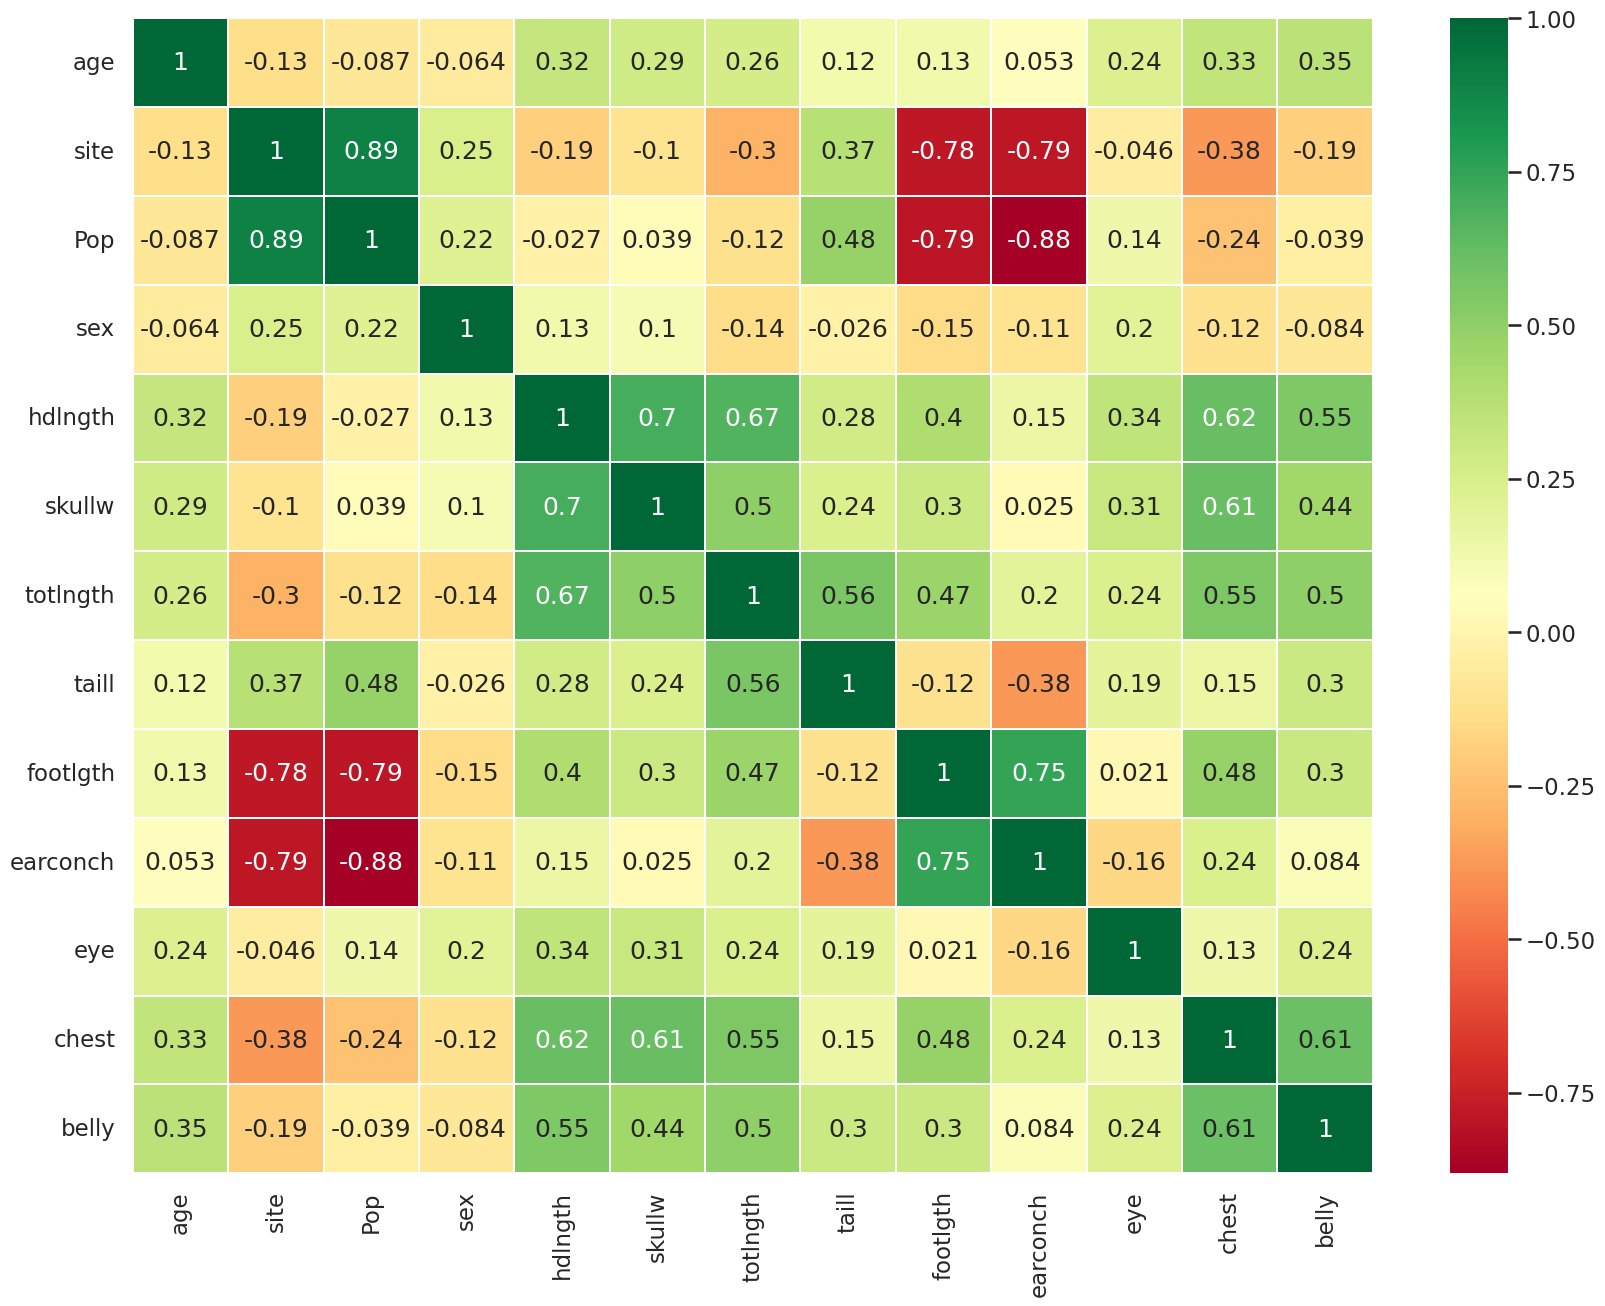

In [44]:
# correlation entre les variables. Tableau de correlations avec les valeurs
plt.figure(figsize=(20,15))
sns.heatmap(data.iloc[:,:].corr(),annot=True,cmap='RdYlGn',linewidths=0.2) #data.corr()-->correlation matrix
plt.show()

### Les variables avec lesquelles l'age est le plus corrélées sont:
- hdlngth : longueur de la tête
- Chest : le tour de poitrine
- belly : le tour de taille
- skullw : la largeur du crâne
- totlngth : la taille total
- footlgth et earconch ont une forte correlation entre elles ont pourra en supprimer une des deux mais peu coréllé avec l'age

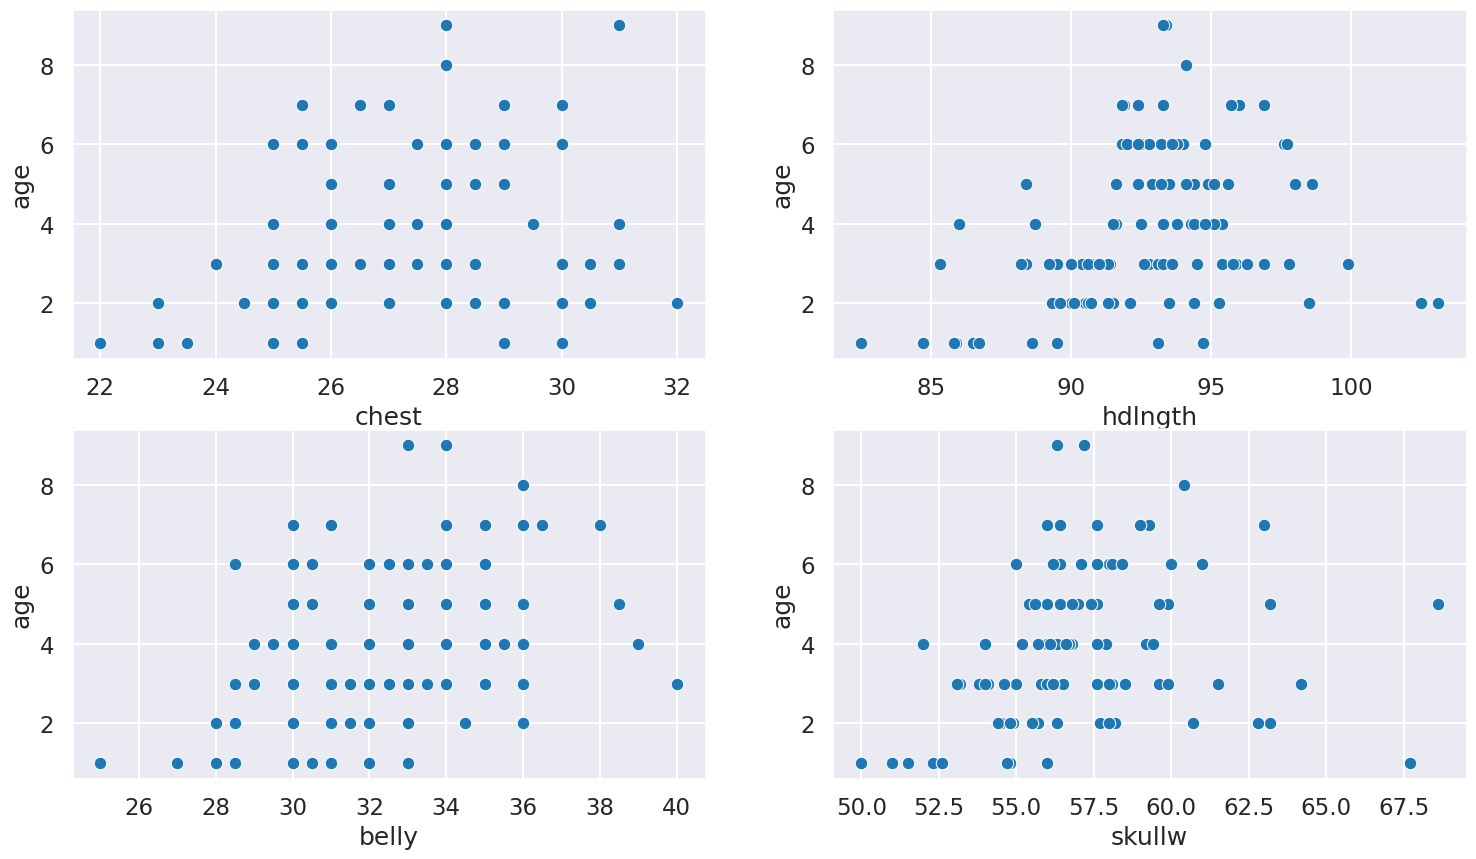

In [45]:
# Avec Seaborn et plusieurs graphique sur un seul affichage :

fig, ax = plt.subplots(2,2,figsize=(18,10)) # 4 graphique (2 lignes, 2 colonnes) taille totale 20,15 en inch

sns.scatterplot(data=data,x="chest",y="age",ax=ax[0,0])    # Lechoix du type de graphique dépend du type de variable
ax[0,0].set_title("")                      # voir doc car beaucoup de possibilités
                                                                                        # boxplot, violinplot, histplot, countplot....
sns.scatterplot(data=data,x="hdlngth",y="age",ax=ax[0,1])
ax[0,1].set_title("")

sns.scatterplot(data=data,x="belly",y="age",ax=ax[1,0])
ax[1,0].set_title("")

sns.scatterplot(data=data,x="skullw",y="age",ax=ax[1,1])
ax[1,1].set_title("")

plt.show()

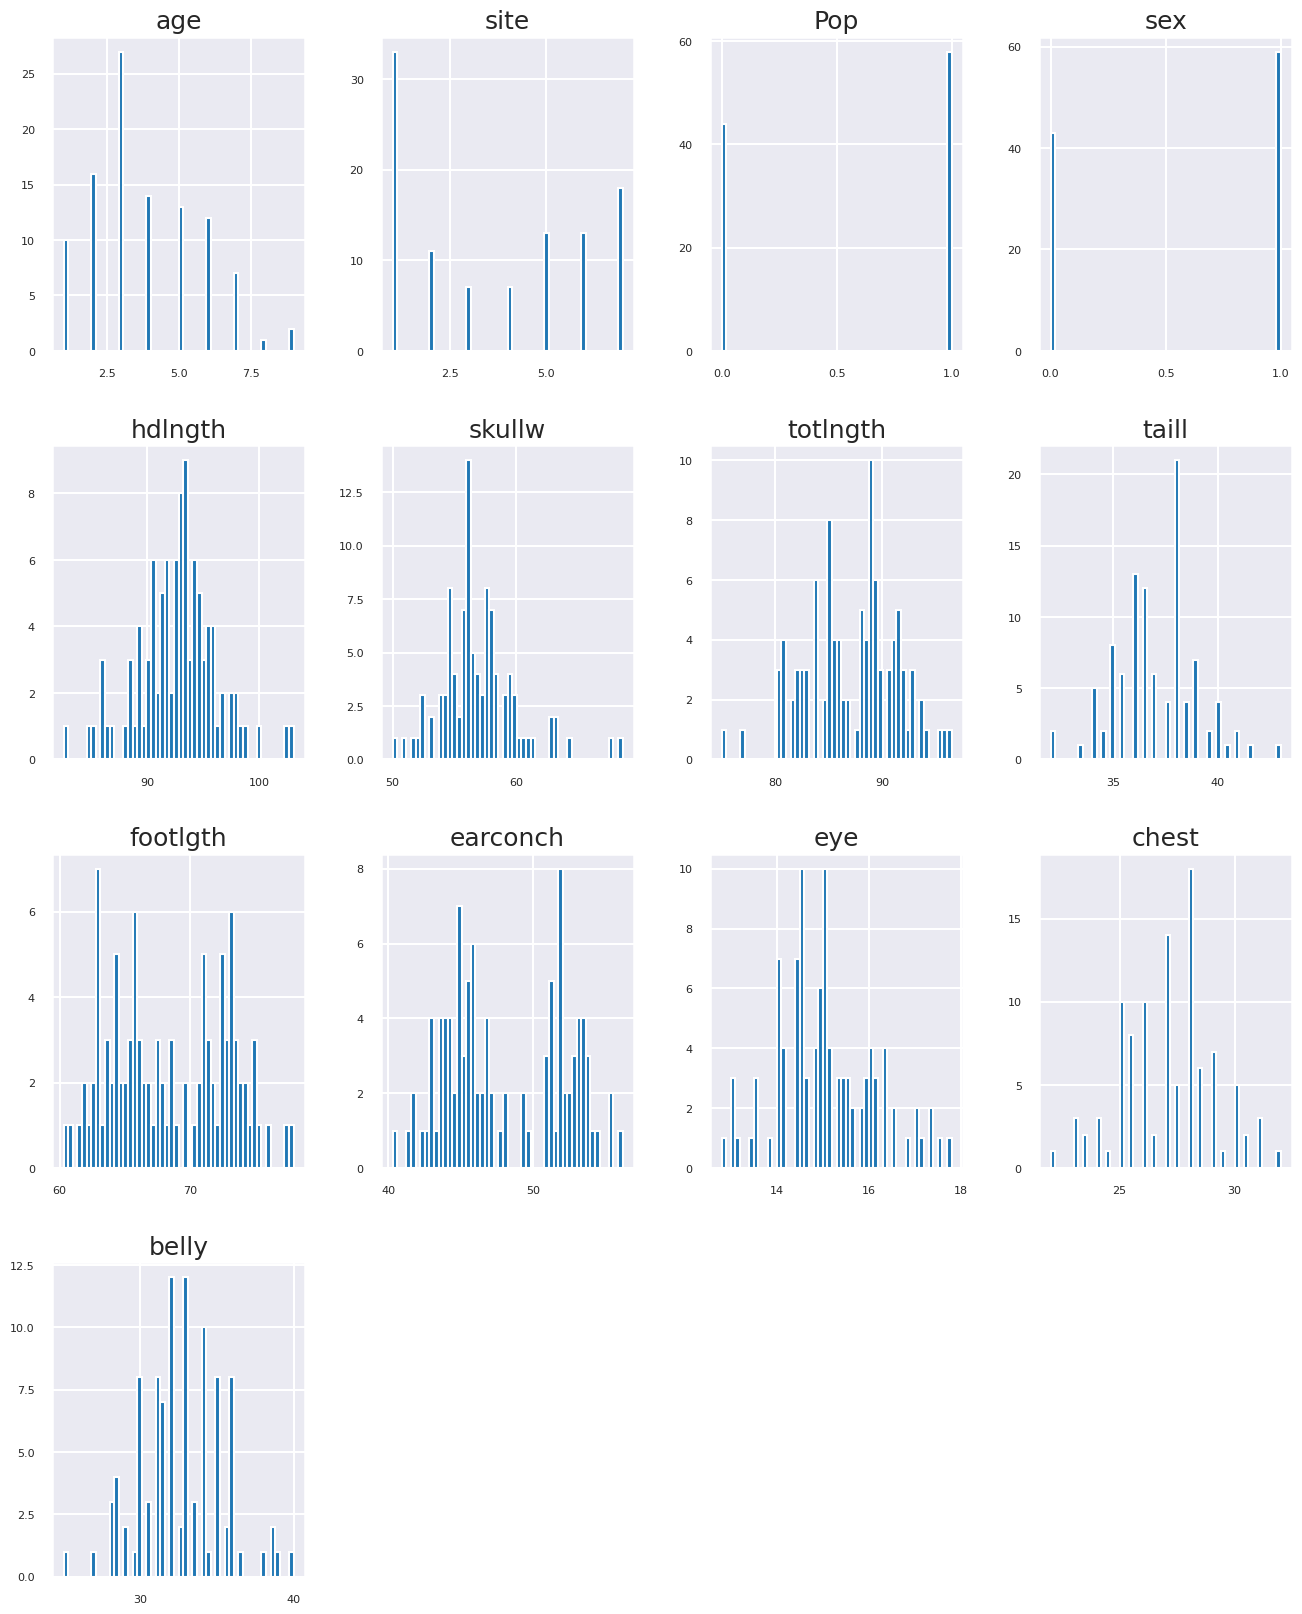

In [46]:
data.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8)
plt.show()

## ___c) Conclusion___

<h4>
<ul>
<li>5 variables sont corrélées linéairement avec l'age</li>
<li>En général, et ce n'est pas une surprise l'age augmente en même temps la taille.</li>
<li>On peu également voir que nos variables ont une distribution normale avec peu de valeurs extrémes.</li>
<li>Autre élément interessant la longueur de pied et la conque auriculaire qui sont fortement corrélées ont l'air d'avoir deux groupes.</li>
<li>Pour determiner l'age on va donc pouvoir utiliser un modèle de regression linéaire</li>
</ul></h4>

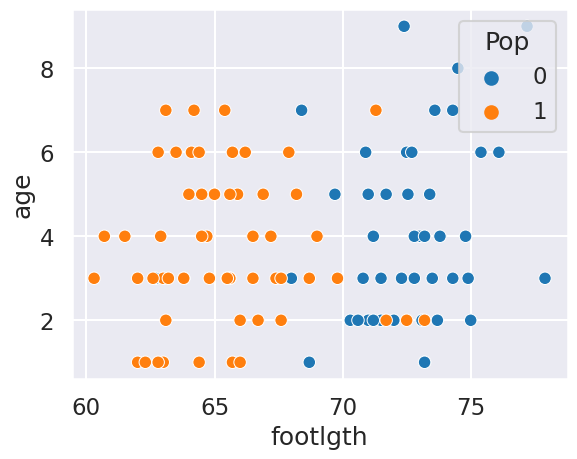

In [58]:
sns.scatterplot(data=data,x="footlgth",y="age",hue="Pop")
plt.show()

<h4>
<ul>
<li>La longueur de pied ou de la conche auriculaire nous permet de definir l'origine mais aucunement l'age</li>
</ul></h4>

# ___4) Selection des variables et Splittage du dataset___

In [48]:
#data.drop(["site","Pop","sex","taill","footlgth","earconch","eye"], axis=1, inplace=True)

In [49]:
data.head()

,age,site,Pop,sex,hdlngth,skullw,totlngth,taill,footlgth,earconch,eye,chest,belly
0,8.0,1,0,1,94.1,60.4,89.0,36.0,74.5,54.5,15.2,28.0,36.0
1,6.0,1,0,0,92.5,57.6,91.5,36.5,72.5,51.2,16.0,28.5,33.0
2,6.0,1,0,0,94.0,60.0,95.5,39.0,75.4,51.9,15.5,30.0,34.0
3,6.0,1,0,0,93.2,57.1,92.0,38.0,76.1,52.2,15.2,28.0,34.0
4,2.0,1,0,0,91.5,56.3,85.5,36.0,71.0,53.2,15.1,28.5,33.0


In [50]:

X_train, X_test, y_train, y_test = train_test_split(data.iloc[:,1:], data.age, test_size=0.2, random_state=3)

# Le dataset sera splitté en 4 un jeu d'entrainement et jeu de test chacun 
# splitté avec d'un côté les variables et de l'autre la sortie
# test_size permet de definir la taille du jeu de test en pourcent
# Random permet d'avoir toujours le même tirage aléatoire

In [51]:
X_train.var(axis=0)


site         5.175000
Pop          0.252160
sex          0.251235
hdlngth     12.369744
skullw       8.374861
totlngth    19.044444
taill        4.057948
footlgth    19.399563
earconch    17.315750
eye          1.023429
chest        4.215818
belly        8.299151
dtype: float64

In [52]:
selector = VarianceThreshold(threshold=8)
selector.fit(X_train)
#X_test = selector.transform(X_test)
concol = [column for column in X_train.columns if column not in X_train.columns[selector.get_support()]]
for features in concol:
    print(features)

X_train = X_train.drop(concol,axis=1)
X_test = X_test.drop(concol,axis=1)

#selector= SelectKBest(chi2,k=8)
#selector.fit_transform(X_train,y_train)
#concol = [column for column in X_train.columns if column not in X_train.columns[selector.get_support()]]
#for features in concol:
#    print(features)
#X_train.drop(concol,axis=1)
#X_test.drop(concol,axis=1)

site
Pop
sex
taill
eye
chest


# Etonnament VarianceTreshold n'a pas gardé la variable chesst qui était correlé à 0,33 avec l'age et à conservé footlgth et earconch ????

---
# Linear Regression
---

In [53]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

scaler = StandardScaler()
X_scaled= scaler.fit_transform(X_train)
model = LinearRegression()
model.fit(X_scaled, y_train)
y_predicted = model.predict(scaler.fit_transform(X_test))
lin_reg_rmse = np.sqrt(mean_squared_error(y_test, y_predicted))
result_r2 = r2_score(y_test, y_predicted)
print(f"le rmse est de ", lin_reg_rmse,"et le r2 est de",result_r2)
    

le rmse est de  1.6330763874411285 et le r2 est de 0.08544333369903945


---
# Polynomial features
---

# J'ai testé avec des degrés supérieur mais ce n'est pas mieux


In [54]:
from sklearn.preprocessing import PolynomialFeatures

scaler_liste = StandardScaler()

X, y = data.iloc[:,1:], data.age

selector = VarianceThreshold(threshold=8)
selector.fit(X)
#X_test = selector.transform(X_test)
concol = [column for column in X.columns if column not in X.columns[selector.get_support()]]
for features in concol:
    print(features)

X = X.drop(concol,axis=1)

poly = PolynomialFeatures(degree=1, include_bias=False)
poly_features = poly.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(poly_features, y, test_size=0.3, random_state=3)

poly_reg_model = LinearRegression()
poly_reg_model.fit(StandardScaler().fit_transform(X_train), y_train)
poly_reg_y_predicted = poly_reg_model.predict(StandardScaler().fit_transform(X_test))
poly_reg_rmse = np.sqrt(mean_squared_error(y_test, poly_reg_y_predicted))
result_r2 = r2_score(y_test, poly_reg_y_predicted)
print(f"le rmse est de ", lin_reg_rmse,"et le r2 est de",result_r2)

site
Pop
sex
taill
eye
chest
belly
le rmse est de  1.6330763874411285 et le r2 est de 0.07422112518754032


---

# KNN Regressor

---

In [55]:
X_train, X_test, y_train, y_test = train_test_split(data.iloc[:,1:], data.age, test_size=0.2, random_state=3)

selector = VarianceThreshold(threshold=8)
selector.fit(X_train)
#X_test = selector.transform(X_test)
concol = [column for column in X_train.columns if column not in X_train.columns[selector.get_support()]]
for features in concol:
    print(features)

X_train = X_train.drop(concol,axis=1)
X_test = X_test.drop(concol,axis=1)

param_grid = {'n_neighbors': np.arange(1, 20),
              'metric': ['euclidean', 'manhattan']}

cv = 5 #ShuffleSplit(4, test_size=0.2)
grid = GridSearchCV(KNeighborsRegressor(), param_grid, cv=cv)
grid.fit(X_train, y_train)
model=grid.best_estimator_
y_pred = model.predict(X_test)
rmse_KNN = np.sqrt(mean_squared_error(y_test, y_pred))
r2_KNN = r2_score(y_test, y_pred)
print("rmse:",rmse_KNN,"  r2",r2_KNN,"best parametre",grid.best_params_)

from joblib import dump
dump(model, 'model_opossum.joblib') 
    

site
Pop
sex
taill
eye
chest
rmse: 1.5851336882180662   r2 0.13835293545878702 best parametre {'metric': 'euclidean', 'n_neighbors': 8}


['model_opossum.joblib']

---
# ___Les meilleurs résultats sont obtenus avec la KNNRegressor et le StandardScaler avec une erreur d'environ 1,58 ans sur la prédiction de l'age et un r2 de 0,14___


### Les variables pour l'appli sont :

In [56]:
X_train.head(n=0)

,hdlngth,skullw,totlngth,footlgth,earconch,belly


---
---
---

---

# Essai avec Random FOrest Regressor

---

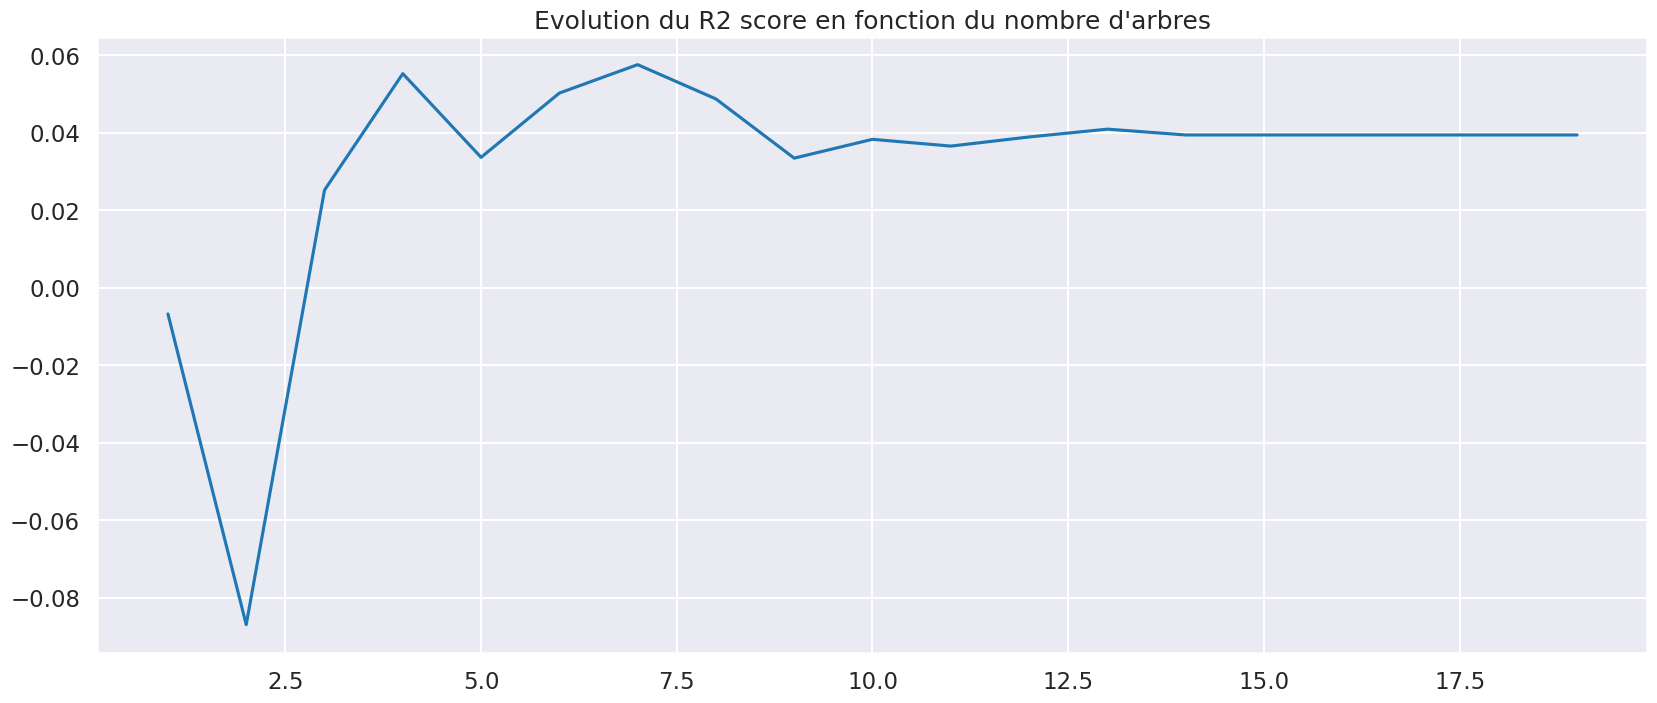

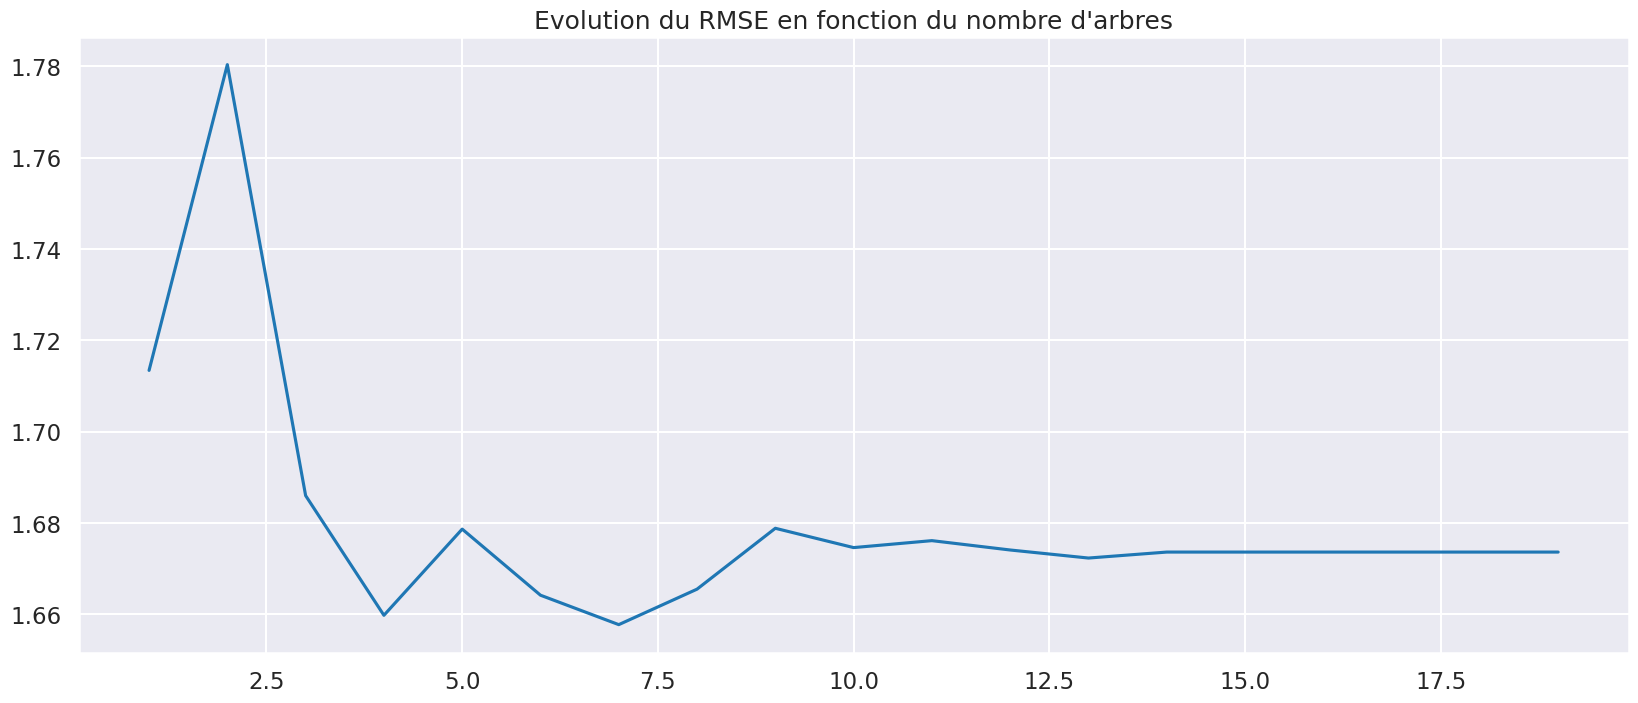

In [62]:
from sklearn.ensemble import RandomForestRegressor
liste_r2,liste_rmse=[],[]
for i in range(1,20):
    regr = RandomForestRegressor(max_depth=i, random_state=0)
    regr.fit(X_train, y_train)
    y_pred = regr.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    liste_r2.append(r2)
    liste_rmse.append(rmse)

plt.figure(figsize=(20,8))
plt.plot(np.arange(1,20),liste_r2)
plt.title("Evolution du R2 score en fonction du nombre d'arbres")
plt.show()

plt.figure(figsize=(20,8))
plt.plot(np.arange(1,20),liste_rmse)
plt.title("Evolution du RMSE en fonction du nombre d'arbres")
plt.show()



## Pas de meilleur résultat avec randomForestRegressor